In [1]:
# ============================================
# Block 0 — Setup & Paths
# ============================================
import os, glob, json, warnings, math
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
warnings.filterwarnings("ignore")
plt.rcParams["figure.dpi"] = 120
sns.set_style("whitegrid")

DATA_DIR = "clean"
REPORT_DIR = os.path.join(DATA_DIR, "report", "nb02")
PLOTS_DIR  = os.path.join(REPORT_DIR, "plots")
TABLES_DIR = os.path.join(REPORT_DIR, "tables")
EXEC_DIR   = os.path.join(DATA_DIR, "exec")

for d in [REPORT_DIR, PLOTS_DIR, TABLES_DIR, EXEC_DIR]:
    os.makedirs(d, exist_ok=True)


def save_table(df, name):
    df.to_csv(os.path.join(TABLES_DIR, f"{name}.csv"), index=False)
    df.to_parquet(os.path.join(TABLES_DIR, f"{name}.parquet"), index=False)


In [2]:
# ==== One-shot Plot Patch (safe to drop anywhere; run once) ====
# Purpose:
# - Show each figure exactly once (no extra empty plots)
# - Capture the plot title at save-time (no plt.gca() afterwards)
# - Keep a global CAPTIONS registry compatible with your existing calls

from IPython.display import display as _display
import matplotlib.pyplot as plt
import os

# Global registry (create if missing)
if "CAPTIONS" not in globals():
    CAPTIONS = []

# Internal buffer to carry last figure's title (used if caller doesn't pass one)
_LAST_FIG_TITLE = ""

def savefig(path: str):
    """
    Patched saver:
    - tight layout
    - save to disk
    - display once
    - close figure (prevents extra empty figures)
    - capture title for captioning without touching plt.gca() later
    """
    global _LAST_FIG_TITLE
    fig = plt.gcf()
    try:
        if fig.axes:
            _LAST_FIG_TITLE = fig.axes[0].get_title() or ""
        else:
            _LAST_FIG_TITLE = ""
    except Exception:
        _LAST_FIG_TITLE = ""

    fig.tight_layout()
    fig.savefig(path, bbox_inches="tight")
    _display(fig)      # show exactly once
    plt.close(fig)     # close so Jupyter doesn't render a blank figure afterward

def register_caption(path: str, caption: str, source_table: str | None = None, title: str | None = None):
    """
    Patched caption recorder:
    - Does NOT touch Matplotlib state.
    - If 'title' is not provided, uses the last title captured by savefig().
    - Backward compatible with existing calls that omit 'title'.
    """
    rec = {
        "file": os.path.basename(path),
        "title": (title if title is not None else _LAST_FIG_TITLE) or "",
        "caption": caption,
        "source_table": source_table
    }
    CAPTIONS.append(rec)

print("[PlotPatch] savefig() and register_caption() patched.")


[PlotPatch] savefig() and register_caption() patched.


In [3]:
# ============================================
# Block 1 — Load DataFrames & Quick Snapshot
# ============================================
paths = sorted(glob.glob(os.path.join(DATA_DIR, "*.parquet")))
assert len(paths) > 0, f"No .parquet files found in {DATA_DIR!r}"

dfs = {}
for p in paths:
    name = os.path.splitext(os.path.basename(p))[0]
    try:
        dfs[name] = pd.read_parquet(p)
        print(f"[load] {name}: {dfs[name].shape[0]:,} rows × {dfs[name].shape[1]} cols")
    except Exception as e:
        print(f"[load-error] {name}: {e}")

sales = dfs.get("sales_enriched", dfs.get("sales"))
assert sales is not None, "Missing sales_enriched/sales."

# policy flags
POLICY = {
    "salesdate_missing_in_time_series": "exclude",
    "salesdate_missing_in_global_kpis": "include",
}
print("Policy:", POLICY)


[load] cities: 96 rows × 5 cols
[load] countries: 206 rows × 3 cols
[load] customers: 98,759 rows × 8 cols
[load] customers_rfm: 98,759 rows × 5 cols
[load] employees: 23 rows × 9 cols
[load] products: 452 rows × 15 cols
[load] sales: 6,758,125 rows × 11 cols
[load] sales_enriched: 6,758,125 rows × 20 cols
Policy: {'salesdate_missing_in_time_series': 'exclude', 'salesdate_missing_in_global_kpis': 'include'}


,ATV (Average Transaction Value),UPT (Units per Transaction)
0,641.07,13.00


,ATV_mean,ATV_median,ATV_p90,UPT_mean,UPT_median,UPT_p90
0,641.07,490.77,"1,472.30",13.00,13.00,23.00


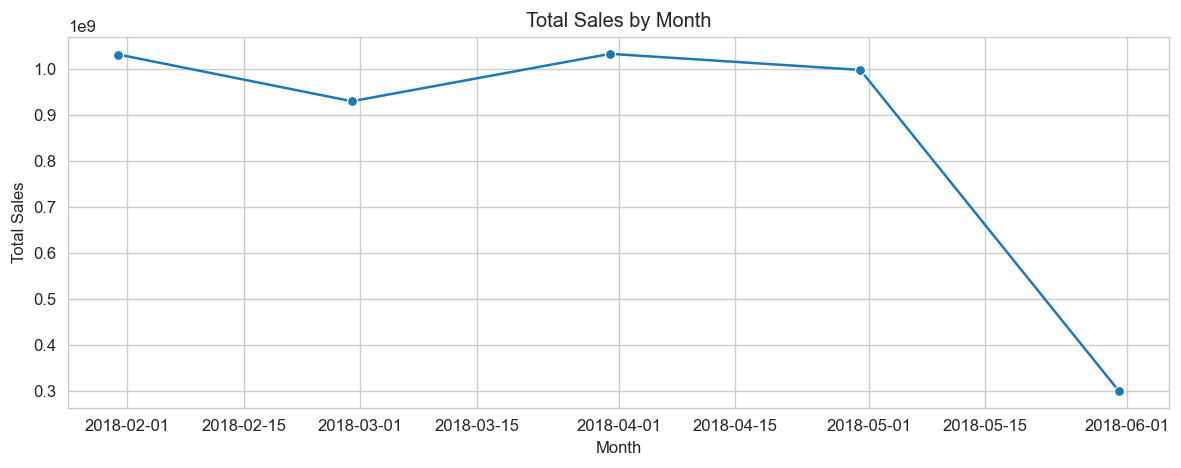

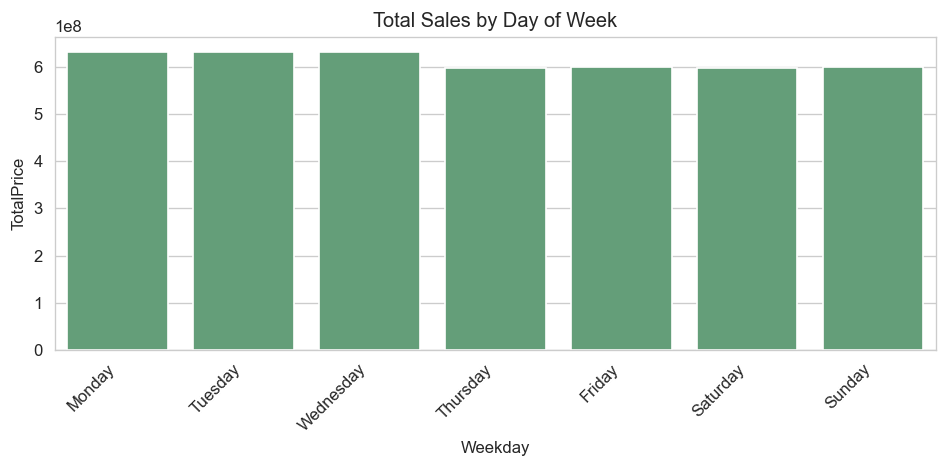

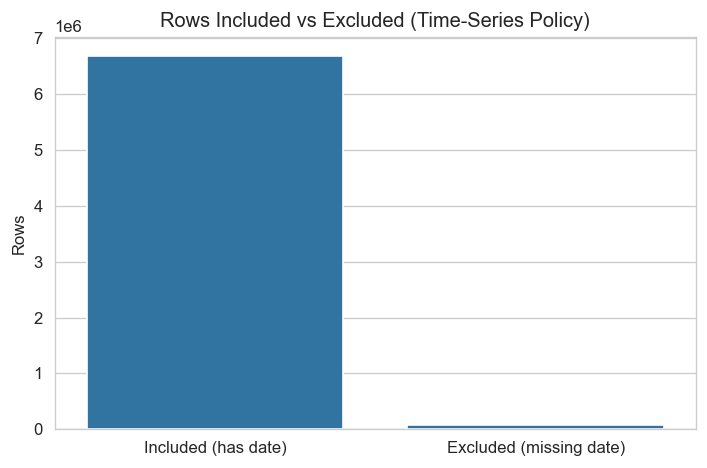

{'ts_excluded_pct': 0.999}


In [4]:
# ============================================
# Block 2 — Core KPIs (ATV / UPT) + Time Series Basics
# ============================================
se = sales.copy()
for c in ["TotalPrice","Quantity","Discount"]:
    if c in se.columns: se[c] = pd.to_numeric(se[c], errors="coerce")

# KPIs at transaction level
atv = se.groupby("SalesID", as_index=False)["TotalPrice"].sum()["TotalPrice"].mean()
upt = se.groupby("SalesID", as_index=False)["Quantity"].sum()["Quantity"].mean()
kpi = pd.DataFrame({"ATV (Average Transaction Value)":[atv], "UPT (Units per Transaction)":[upt]})
display(kpi.style.format({"ATV (Average Transaction Value)":"{:,.2f}",
                          "UPT (Units per Transaction)":"{:,.2f}"}))
save_table(kpi, "kpi_atv_upt")
# === NEW: Robust KPIs (median & P90) ===
# Build per-transaction aggregates first
_tx = se.groupby("SalesID", as_index=False).agg(
    TotalPrice=("TotalPrice", "sum"),
    Quantity=("Quantity", "sum"),
)

def _p90(x):
    return float(np.nanpercentile(x, 90))

kpi_ext = pd.DataFrame({
    "ATV_mean":   [float(_tx["TotalPrice"].mean())],
    "ATV_median": [float(_tx["TotalPrice"].median())],
    "ATV_p90":    [float(_p90(_tx["TotalPrice"]))],
    "UPT_mean":   [float(_tx["Quantity"].mean())],
    "UPT_median": [float(_tx["Quantity"].median())],
    "UPT_p90":    [float(_p90(_tx["Quantity"]))],
})
display(kpi_ext.style.format("{:,.2f}"))
save_table(kpi_ext, "kpi_atv_upt_extended")

# Time series (exclude null dates by policy)
if "SalesDate" in se.columns:
    ts = se.dropna(subset=["SalesDate"]).copy()
    ts["SalesDate"] = pd.to_datetime(ts["SalesDate"], errors="coerce")
    monthly = ts.groupby(pd.Grouper(key="SalesDate", freq="M"))["TotalPrice"].sum().reset_index()

    plt.figure(figsize=(10,4))
    sns.lineplot(data=monthly, x="SalesDate", y="TotalPrice", marker="o")
    plt.title("Total Sales by Month"); plt.xlabel("Month"); plt.ylabel("Total Sales")
    savefig(os.path.join(PLOTS_DIR, "sales_monthly_line.png"))
    register_caption(os.path.join(PLOTS_DIR, "sales_monthly_line.png"),
                 "Monthly total sales (rows with valid SalesDate only; policy excludes null dates).",
                 "sales_monthly_totals")
    save_table(monthly, "sales_monthly_totals")

    dow = (ts.assign(Weekday=lambda x: x["SalesDate"].dt.day_name())
             .groupby("Weekday")["TotalPrice"].sum()
             .reindex(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
             .reset_index())
    plt.figure(figsize=(8,4))
    sns.barplot(data=dow, x="Weekday", y="TotalPrice", color="#5ba776")
    plt.xticks(rotation=45, ha="right"); plt.title("Total Sales by Day of Week")
    savefig(os.path.join(PLOTS_DIR, "sales_by_weekday_bar.png"))
    register_caption(os.path.join(PLOTS_DIR, "sales_by_weekday_bar.png"),
                 "Total sales aggregated by weekday (valid dates only).",
                 "sales_weekday_totals")
    save_table(dow, "sales_weekday_totals")
# === NEW: Quantify policy impact (rows excluded from time series) ===
total_rows = int(len(se))
excluded_rows = int(se["SalesDate"].isna().sum()) if "SalesDate" in se.columns else 0
ts_excluded_pct = (100.0 * excluded_rows / max(total_rows, 1))

incl_tbl = pd.DataFrame([
    {"Bucket": "Included (has date)", "Rows": total_rows - excluded_rows},
    {"Bucket": "Excluded (missing date)", "Rows": excluded_rows},
])
plt.figure(figsize=(6, 4))
sns.barplot(data=incl_tbl, x="Bucket", y="Rows")
plt.title("Rows Included vs Excluded (Time-Series Policy)")
plt.xlabel(""); plt.ylabel("Rows")
savefig(os.path.join(PLOTS_DIR, "ts_included_vs_excluded.png"))
register_caption(os.path.join(PLOTS_DIR, "ts_included_vs_excluded.png"),
                 "Rows included vs excluded in time-series computations, per date-policy.",
                 "ts_included_vs_excluded")
save_table(incl_tbl, "ts_included_vs_excluded")

print({"ts_excluded_pct": round(ts_excluded_pct, 3)})


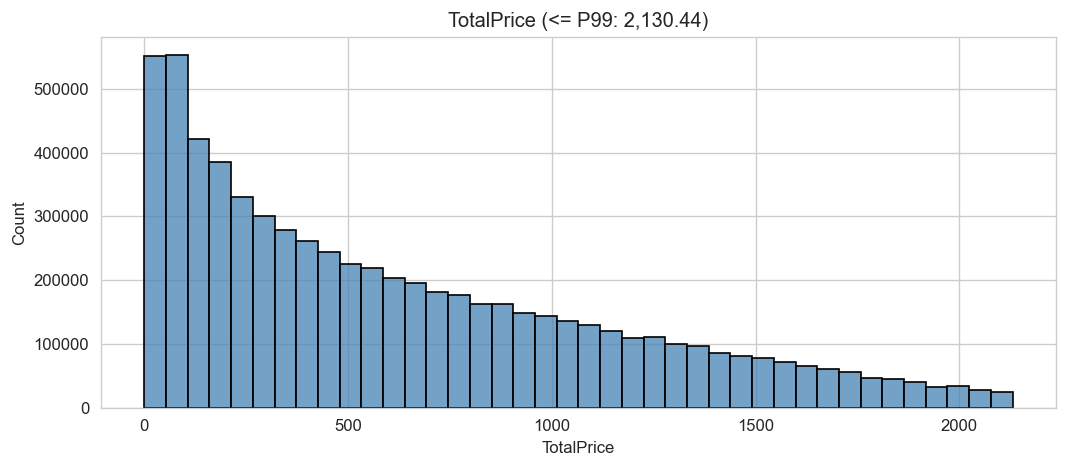

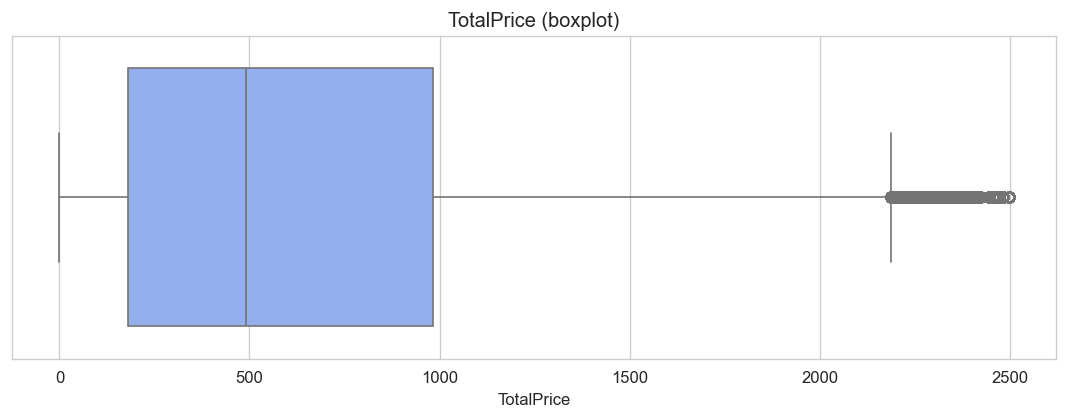

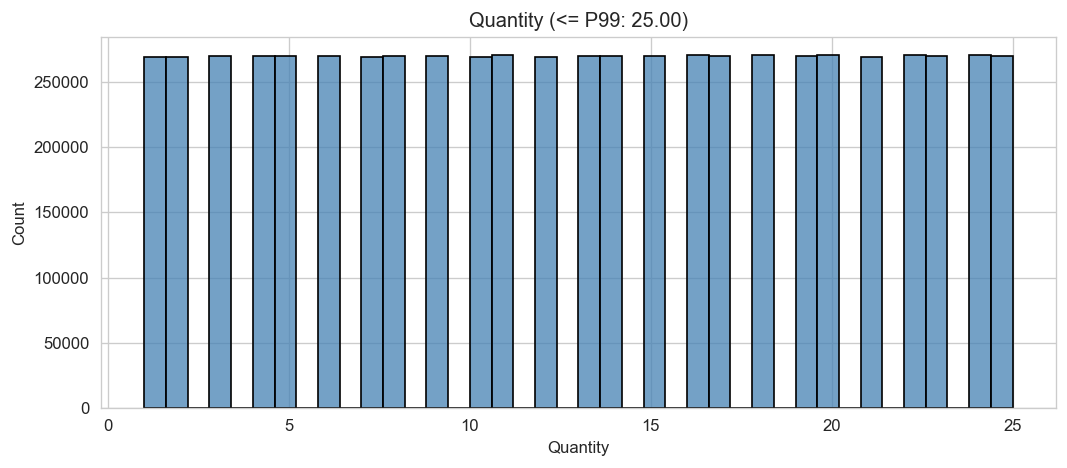

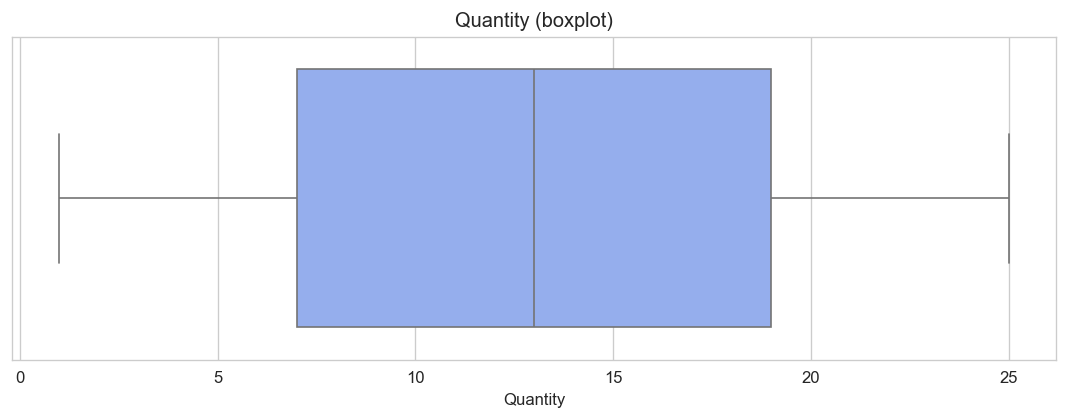

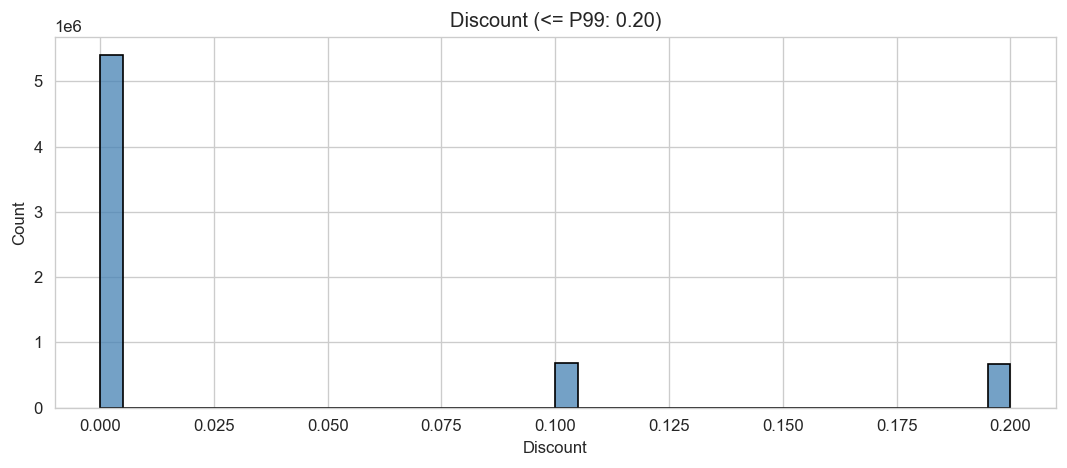

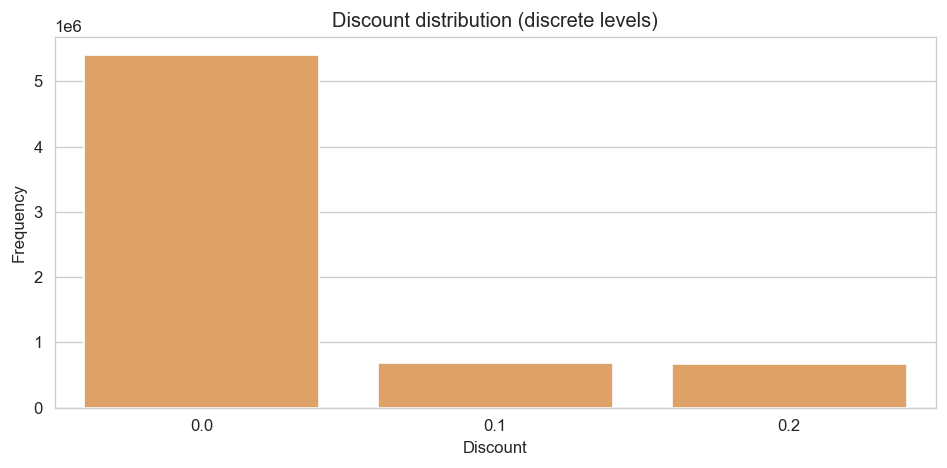

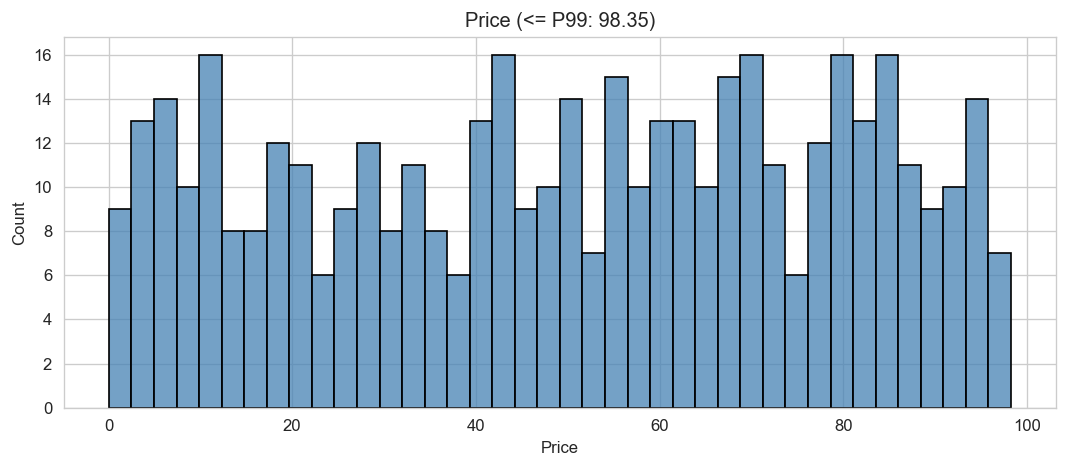

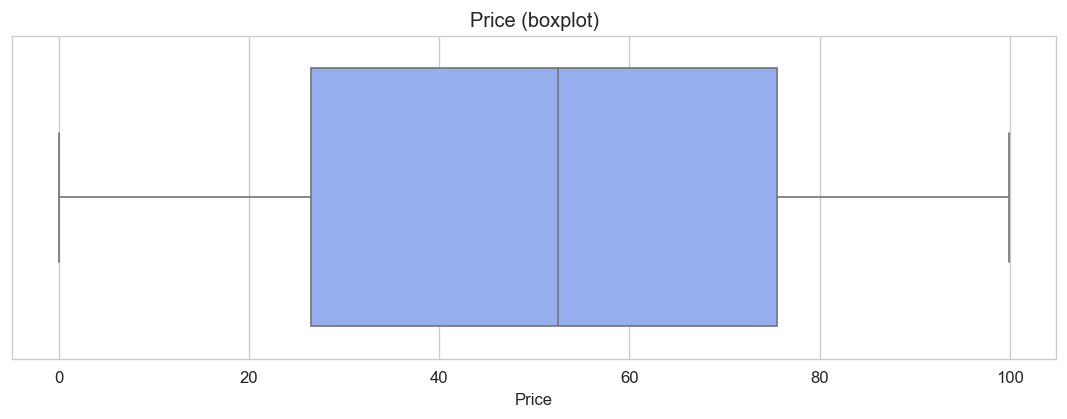

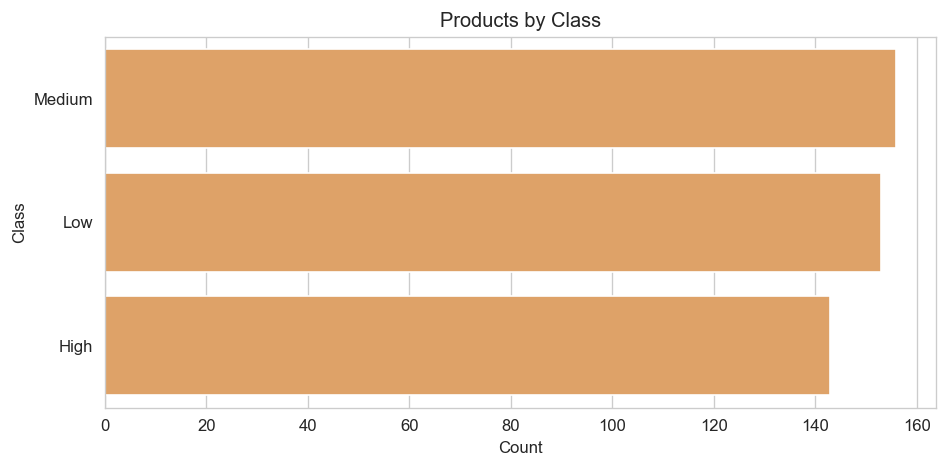

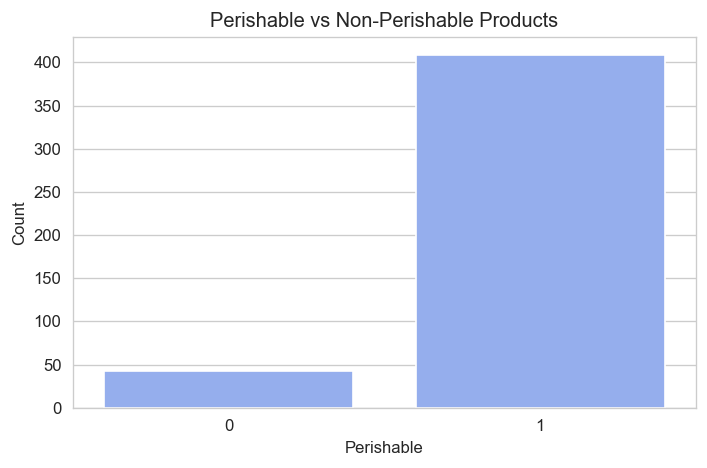

In [5]:
# ============================================
# Block 3 — Distributions & Outliers (Sales & Products)
# ============================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# ---------- Helpers (lightweight, memory-safe)
def hist_trim(s, title, bins=40, fname=None, color="steelblue"):
    s = pd.to_numeric(s, errors="coerce").dropna()
    if s.empty:
        return
    p99 = s.quantile(0.99)
    plt.figure(figsize=(9, 4))
    sns.histplot(s[s <= p99], bins=bins, color=color, edgecolor="black")
    plt.title(f"{title} (<= P99: {p99:,.2f})")
    plt.xlabel(title); plt.ylabel("Count")
    if fname: 
        out_path = os.path.join(PLOTS_DIR, fname)
        savefig(out_path)
        # NEW: caption
        register_caption(
            out_path,
            f"Distribution of {title} trimmed at the 99th percentile (P99={p99:,.2f}) to reduce extreme values."
        )

def box_basic(s, title, fname=None):
    s = pd.to_numeric(s, errors="coerce").dropna()
    if s.empty:
        return
    plt.figure(figsize=(9, 3.6))
    sns.boxplot(x=s, color="#86a8fc")
    plt.title(f"{title} (boxplot)")
    plt.xlabel(title)
    if fname:
        out_path = os.path.join(PLOTS_DIR, fname)
        savefig(out_path)
        # NEW: caption
        register_caption(
            out_path,
            f"Boxplot of {title}; whiskers show IQR-based spread and highlight outliers for quality checks."
        )

# ---------- Sales distributions
se = dfs["sales_enriched"].copy()
for c in ["TotalPrice", "Quantity", "Discount"]:
    if c in se.columns:
        se[c] = pd.to_numeric(se[c], errors="coerce")

hist_trim(se["TotalPrice"], "TotalPrice", fname="sales_totalprice_hist.png")
box_basic(se["TotalPrice"],  "TotalPrice", fname="sales_totalprice_box.png")

hist_trim(se["Quantity"], "Quantity", fname="sales_quantity_hist.png")
box_basic(se["Quantity"],  "Quantity", fname="sales_quantity_box.png")

hist_trim(se["Discount"], "Discount", fname="sales_discount_hist.png")

# If Discount has a few discrete values, add a countplot (nice for % off ladders)
disc = se["Discount"].dropna()
if not disc.empty and disc.nunique() <= 10:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=disc, color="#f2a154", order=sorted(disc.unique()))
    plt.title("Discount distribution (discrete levels)")
    plt.xlabel("Discount"); plt.ylabel("Frequency")
    out_path = os.path.join(PLOTS_DIR, "sales_discount_count.png")
    savefig(out_path)
    # NEW: caption
    register_caption(
        out_path,
        "Frequency of discrete discount levels (e.g., 0%, 10%, 20%); useful to audit pricing ladders."
    )

# ---------- Products distributions & composition
pro = dfs["products"].copy()
for c in ["Price", "UnitCost"]:
    if c in pro.columns:
        pro[c] = pd.to_numeric(pro[c], errors="coerce")

# Price hist/box
if "Price" in pro.columns:
    hist_trim(pro["Price"], "Price", fname="products_price_hist.png")
    box_basic(pro["Price"],  "Price", fname="products_price_box.png")

# Composition: Class (fixed)
if "Class" in pro.columns:
    class_counts = (
        pro["Class"]
        .value_counts(dropna=False)
        .rename_axis("Class")
        .reset_index(name="Count")
        .sort_values("Count", ascending=False)
    )
    plt.figure(figsize=(8, 4))
    sns.barplot(data=class_counts, x="Count", y="Class", color="#f2a154")
    plt.title("Products by Class"); plt.xlabel("Count"); plt.ylabel("Class")
    out_path = os.path.join(PLOTS_DIR, "products_class_counts.png")
    savefig(out_path)
    save_table(class_counts, "products_class_counts")
    # NEW: caption
    register_caption(
        out_path,
        "Number of products by Class; helps explain assortment composition for executive stakeholders.",
        source_table="products_class_counts"
    )

# Composition: Perishable vs Non-Perishable
if "Perishable" in pro.columns:
    per_counts = (
        pro["Perishable"]
        .value_counts(dropna=False)
        .rename_axis("Perishable")
        .reset_index(name="Count")
        .sort_values("Count", ascending=False)
    )
    plt.figure(figsize=(6, 4))
    sns.barplot(data=per_counts, x="Perishable", y="Count", color="#86a8fc")
    plt.title("Perishable vs Non-Perishable Products")
    plt.xlabel("Perishable"); plt.ylabel("Count")
    out_path = os.path.join(PLOTS_DIR, "products_perishable_counts.png")
    savefig(out_path)
    save_table(per_counts, "products_perishable_counts")
    # NEW: caption
    register_caption(
        out_path,
        "Count of products by Perishable flag (1=perishable, 0=non-perishable); informs inventory policy.",
        source_table="products_perishable_counts"
    )


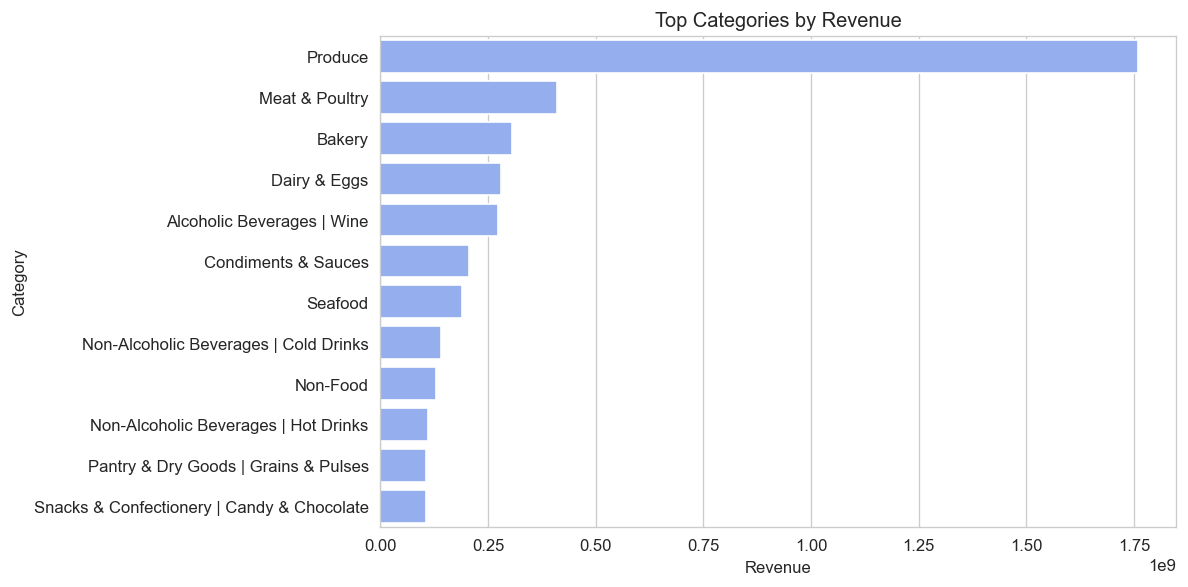

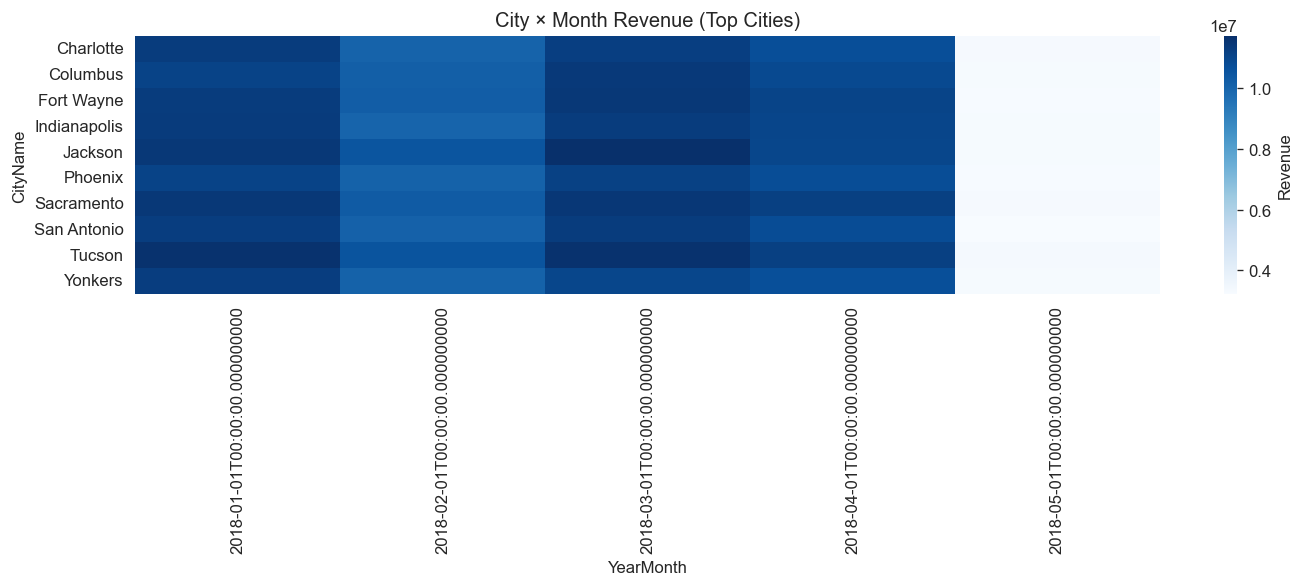

In [6]:
# ============================================
# Block 4 — Top-N Products/Categories & Geo Heatmap
# ============================================
# ensure Category exists in sales (merge if required)
cols_needed = ["ProductID","Category","Class","Perishable","Price"]
if not set(cols_needed).issubset(se.columns):
    se = se.merge(pro[["ProductID","Category","Class","Perishable","Price"]], on="ProductID", how="left", validate="many_to_one")

# Top products
top_prod = se.groupby("ProductID")["TotalPrice"].sum().sort_values(ascending=False).head(10).reset_index()
save_table(top_prod, "top10_products_by_sales")

# Top categories
if "Category" in se.columns:
    top_cat = (se.groupby("Category")["TotalPrice"].sum()
                 .sort_values(ascending=False).head(12).reset_index()
                 .rename(columns={"TotalPrice":"Revenue"}))
    plt.figure(figsize=(10,5))
    sns.barplot(data=top_cat, x="Revenue", y="Category", color="#86a8fc")
    plt.title("Top Categories by Revenue")
    savefig(os.path.join(PLOTS_DIR, "sales_top_categories_by_revenue.png"))
    register_caption(os.path.join(PLOTS_DIR, "sales_top_categories_by_revenue.png"),
                 "Top categories by revenue (bars sorted descending).",
                 "sales_top_categories_by_revenue")
    save_table(top_cat, "sales_top_categories_by_revenue")

# City × Month heatmap (exclude null dates)
if {"SalesDate","CustomerID"}.issubset(se.columns):
    # Attach City & Country via dimensions if missing
    if "CityName" not in se.columns and "customers" in dfs and "cities" in dfs and "countries" in dfs:
        se = (se.merge(dfs["customers"][["CustomerID","CityID"]], on="CustomerID", how="left")
                .merge(dfs["cities"][["CityID","CityName","CountryID"]], on="CityID", how="left")
                .merge(dfs["countries"][["CountryID","CountryName"]], on="CountryID", how="left"))
    ts2 = se.dropna(subset=["SalesDate","CityName"]).copy()
    ts2["SalesDate"] = pd.to_datetime(ts2["SalesDate"], errors="coerce")
    ts2["YearMonth"] = ts2["SalesDate"].dt.to_period("M").dt.to_timestamp()
    # top cities by revenue
    top_cities = ts2.groupby("CityName")["TotalPrice"].sum().sort_values(ascending=False).head(10).index.tolist()
    heat_df = (ts2[ts2["CityName"].isin(top_cities)]
               .groupby(["CityName","YearMonth"])["TotalPrice"].sum().reset_index())
    pivot = heat_df.pivot(index="CityName", columns="YearMonth", values="TotalPrice").fillna(0)
    plt.figure(figsize=(12, max(4, 0.5*len(top_cities))))
    sns.heatmap(pivot, cmap="Blues", cbar_kws={"label":"Revenue"})
    plt.title("City × Month Revenue (Top Cities)")
    savefig(os.path.join(PLOTS_DIR, "sales_city_by_month_heatmap.png"))
    register_caption(os.path.join(PLOTS_DIR, "sales_city_by_month_heatmap.png"),
                 "City × Month revenue heatmap (top revenue cities; valid dates only).",
                 "sales_city_by_month_pivot")
    save_table(pivot.reset_index(), "sales_city_by_month_pivot")


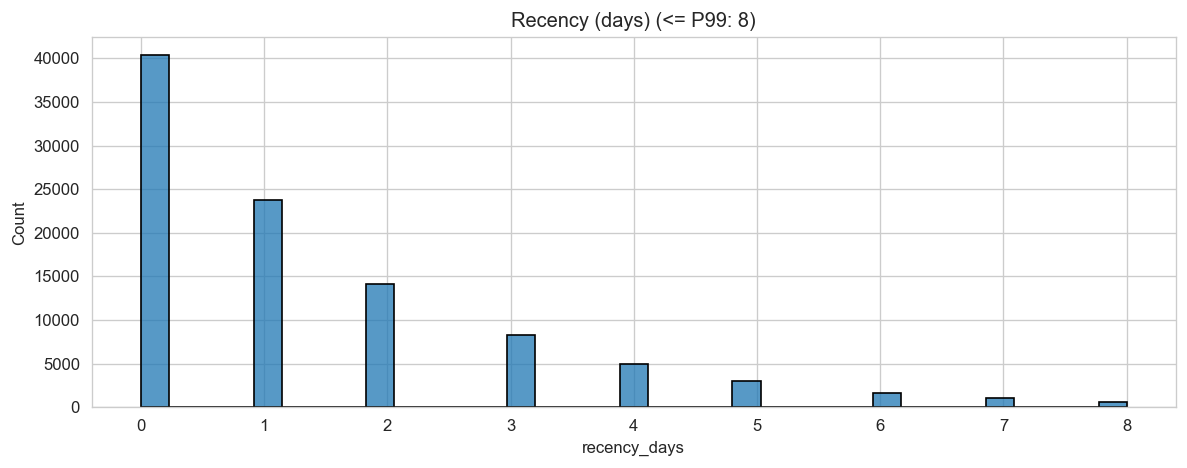

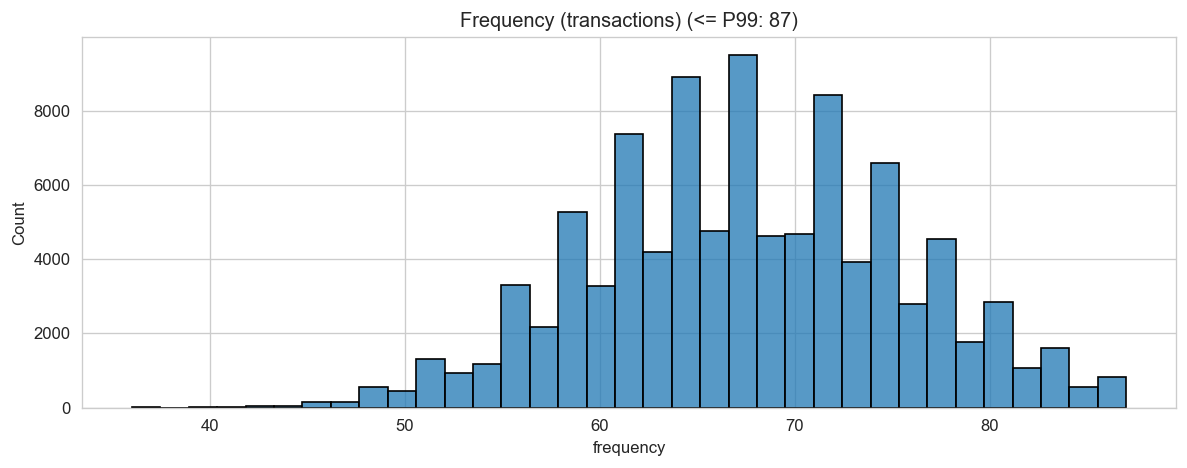

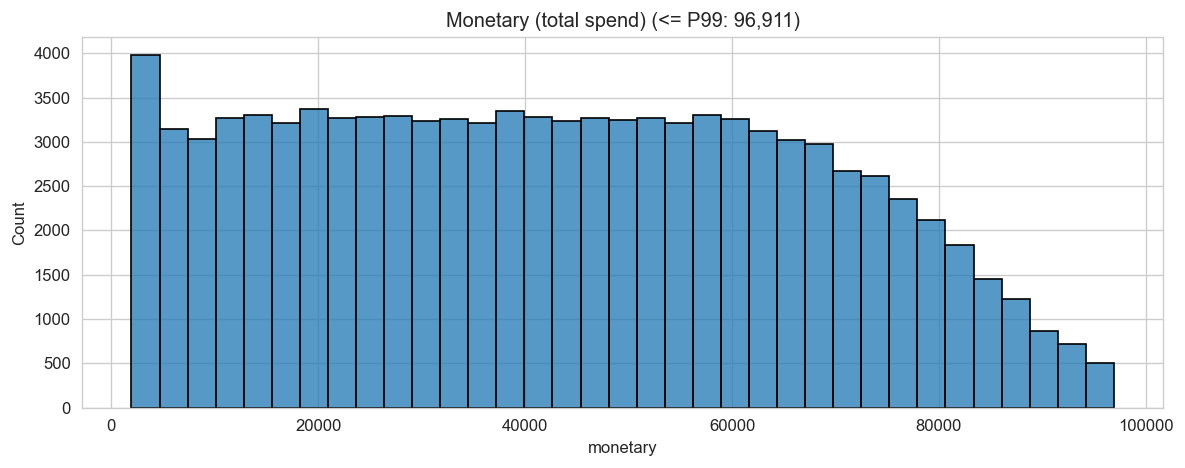

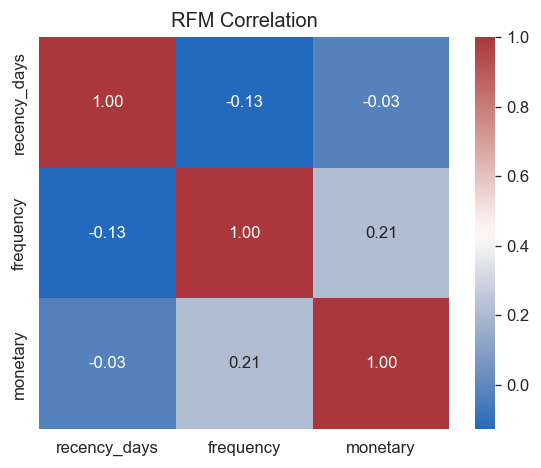

In [7]:
# ============================================
# Block 5 — RFM (Recency, Frequency, Monetary)
# ============================================
se_rfm = se.dropna(subset=["SalesDate"]).copy()
se_rfm["SalesDate"] = pd.to_datetime(se_rfm["SalesDate"], errors="coerce")
ref_date = se_rfm["SalesDate"].max()

txn = (se_rfm.groupby(["SalesID","CustomerID"], as_index=False)
       .agg(SalesDate=("SalesDate","max"), TotalPrice=("TotalPrice","sum")))

rfm = (txn.groupby("CustomerID", as_index=False)
        .agg(last_date=("SalesDate","max"),
             frequency=("SalesID","count"),
             monetary=("TotalPrice","sum")))

rfm["recency_days"] = (ref_date - rfm["last_date"]).dt.days

# --- Distributions (trimmed at P99) + captions
for col, fname, title in [
    ("recency_days","rfm_recency_(days)_hist.png","Recency (days)"),
    ("frequency","rfm_frequency_(transactions)_hist.png","Frequency (transactions)"),
    ("monetary","rfm_monetary_(total_spend)_hist.png","Monetary (total spend)")
]:
    s = pd.to_numeric(rfm[col], errors="coerce")
    if s.notna().sum() == 0:
        continue
    p99 = s.quantile(0.99)
    plt.figure(figsize=(10,4))
    sns.histplot(s[s <= p99], bins=35, edgecolor="black")
    plt.title(f"{title} (<= P99: {p99:,.0f})")
    out_path = os.path.join(PLOTS_DIR, fname)
    savefig(out_path)
    # NEW: caption
    register_caption(
        out_path,
        f"RFM {title}: distribution trimmed at the 99th percentile (P99={p99:,.0f}) to reduce extreme values. "
        "Recency is computed as days since the customer's last purchase relative to the dataset reference date.",
        source_table="rfm_describe"
    )

# --- Correlation heatmap + caption
corr = rfm[["recency_days","frequency","monetary"]].corr()
plt.figure(figsize=(4.8,4))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="vlag")
plt.title("RFM Correlation")
out_path = os.path.join(PLOTS_DIR, "rfm_correlation_heatmap.png")
savefig(out_path)
# NEW: caption
register_caption(
    out_path,
    "Correlation matrix for RFM features (Recency, Frequency, Monetary). "
    "Typical retail patterns: negative correlation between Recency and Frequency/Monetary (more recent buyers tend to buy more).",
    source_table="rfm_describe"
)

# --- Top customers (exec table for later use)
top_customers = (
    rfm.merge(dfs["customers"][["CustomerID","CityID"]], on="CustomerID", how="left")
       .merge(dfs["cities"][["CityID","CityName","CountryID"]], on="CityID", how="left")
       .merge(dfs["countries"][["CountryID","CountryName"]], on="CountryID", how="left")
       .sort_values("monetary", ascending=False)
       .head(10)[["CustomerID","monetary","frequency","recency_days","CityName","CountryName"]]
)
save_table(top_customers, "rfm_top_customers")

# --- Describe table for RFM + export full RFM
rfm_desc = rfm[["recency_days","frequency","monetary"]].describe().reset_index()
save_table(rfm_desc, "rfm_describe")
rfm.to_parquet(os.path.join(DATA_DIR, "customers_rfm.parquet"), index=False)


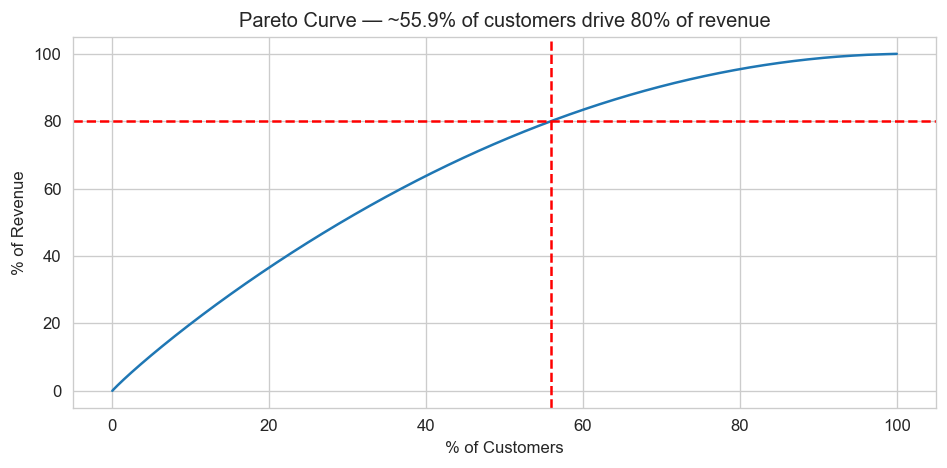

{'HHI': 0.010426409656857179, 'Gini': 0.017244861551723778, 'Top5_share_pct': 5.551498762530923}


In [8]:
# ============================================
# Block 6 — Pareto (80/20) & Concentration Metrics
# ============================================
# Pareto by customer
cust_rev = se.groupby("CustomerID")["TotalPrice"].sum().sort_values(ascending=False).reset_index()
cust_rev["cum_share"] = cust_rev["TotalPrice"].cumsum() / cust_rev["TotalPrice"].sum()

# what share of customers explains 80% revenue?
n_customers = len(cust_rev)
k_80 = (cust_rev["cum_share"] <= 0.80).sum()
pareto_pct = 100 * k_80 / max(n_customers,1)

plt.figure(figsize=(8,4))
plt.plot(np.arange(1, n_customers+1)/n_customers*100, cust_rev["cum_share"]*100)
plt.axhline(80, color="red", linestyle="--")
plt.axvline(pareto_pct, color="red", linestyle="--")
plt.xlabel("% of Customers"); plt.ylabel("% of Revenue")
plt.title(f"Pareto Curve — ~{pareto_pct:.1f}% of customers drive 80% of revenue")
savefig(os.path.join(PLOTS_DIR, "pareto_customers_revenue.png"))
register_caption(os.path.join(PLOTS_DIR, "pareto_customers_revenue.png"),
                 "Pareto curve: share of customers vs share of revenue (red lines indicate the 80% threshold).",
                 "concentration_metrics_city")
# geographic concentration (HHI / Gini / Top-5)
city_share = se.groupby("CityName", dropna=True)["TotalPrice"].sum().rename("Revenue").reset_index()
if not city_share.empty:
    city_share["Share"] = city_share["Revenue"] / city_share["Revenue"].sum()
    hhi  = float((city_share["Share"]**2).sum())
    ss   = np.sort(city_share["Revenue"].values)
    cum_y = np.cumsum(ss)/ss.sum()
    cum_x = np.arange(1,len(ss)+1)/len(ss)
    gini = 1 - np.sum((cum_y + np.r_[0,cum_y[:-1]]) * (cum_x - np.r_[0,cum_x[:-1]]))
    top5_share = city_share.sort_values("Share", ascending=False)["Share"].head(5).sum()*100
else:
    hhi=gini=top5_share=np.nan

conc_tbl = pd.DataFrame([{"HHI":hhi, "Gini":gini, "Top5_share_pct":top5_share}])
save_table(conc_tbl, "concentration_metrics_city")
print({"HHI":hhi, "Gini":gini, "Top5_share_pct":top5_share})


In [9]:
# ============================================
# Block 7 — Executive Packaging (ready for Tableau/Report)
# ============================================
def _fmt_musd(x): return round(x/1e6, 3)
rev_total = se["TotalPrice"].sum()

exec_tables = {}

if "Category" in se.columns:
    by_cat = (se.groupby("Category")["TotalPrice"].sum().reset_index()
                .rename(columns={"TotalPrice":"Revenue"}).sort_values("Revenue", ascending=False))
    by_cat["Share_%"] = 100 * by_cat["Revenue"] / max(rev_total,1)
    by_cat["Revenue_MUSD"] = by_cat["Revenue"].map(_fmt_musd)
    exec_tables["top_categories"] = by_cat

if "Class" in se.columns:
    by_cls = (se.groupby("Class")["TotalPrice"].sum().reset_index()
                .rename(columns={"TotalPrice":"Revenue"}).sort_values("Revenue", ascending=False))
    by_cls["Share_%"] = 100 * by_cls["Revenue"] / max(rev_total,1)
    by_cls["Revenue_MUSD"] = by_cls["Revenue"].map(_fmt_musd)
    exec_tables["class_summary"] = by_cls

if "Perishable" in se.columns:
    by_per = (se.groupby("Perishable")["TotalPrice"].sum().reset_index()
               .rename(columns={"TotalPrice":"Revenue"}).sort_values("Revenue", ascending=False))
    by_per["Share_%"] = 100 * by_per["Revenue"] / max(rev_total,1)
    by_per["Revenue_MUSD"] = by_per["Revenue"].map(_fmt_musd)
    exec_tables["perishable_summary"] = by_per

if "CityName" in se.columns:
    by_city = (se.groupby("CityName")["TotalPrice"].sum().reset_index()
                .rename(columns={"TotalPrice":"Revenue"}).sort_values("Revenue", ascending=False).head(15))
    by_city["Share_%"] = 100 * by_city["Revenue"] / max(rev_total,1)
    by_city["Revenue_MUSD"] = by_city["Revenue"].map(_fmt_musd)
    exec_tables["top_cities"] = by_city

for name, df in exec_tables.items():
    df.to_csv(os.path.join(EXEC_DIR, f"{name}.csv"), index=False)
    df.to_parquet(os.path.join(EXEC_DIR, f"{name}.parquet"), index=False)

print(f"Saved executive tables → {EXEC_DIR}")


Saved executive tables → clean\exec


In [10]:
# ============================================
# Block 8 — Narrative Insights (dynamic)
# ============================================
# Safe getters (in case some tables aren't present)
def _safe_top_value(df, col_name):
    try:
        return df.iloc[0][col_name]
    except Exception:
        return "N/A"

# Pull dynamic values from previously computed tables/vars
category_top = _safe_top_value(exec_tables.get("top_categories", pd.DataFrame()), "Category")
perishable_share_pct = None
if "perishable_summary" in exec_tables:
    ps = exec_tables["perishable_summary"]
    perishable_share_pct = float(ps.loc[ps["Perishable"] == 1, "Share_%"].sum()) if 1 in ps["Perishable"].unique() else 0.0

# HHI classification (antitrust-style)
def _hhi_class(x):
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return "N/A"
    return "Low" if x < 0.15 else ("Moderate" if x < 0.25 else "High")

hhi_class = _hhi_class(hhi)
top5_share_pct = None if (isinstance(top5_share, float) and np.isnan(top5_share)) else float(top5_share)

# Pareto from Block 6 (already computed)
pareto_pct_dyn = float(pareto_pct)

# Top city and its share (if available)
top_city_name = _safe_top_value(exec_tables.get("top_cities", pd.DataFrame()), "CityName")
top_city_share = None
if "top_cities" in exec_tables and not exec_tables["top_cities"].empty:
    top_city_share = float(exec_tables["top_cities"].iloc[0]["Share_%"])

# Render Markdown dynamically
lines = [
    "### Executive Highlights (EDA V2 — dynamic)",
    f"- **ATV** ≈ {atv:,.2f} and **UPT** ≈ {upt:,.2f}.",
    f"- **Date coverage policy**: rows with missing `SalesDate` are excluded from time-series but included in global KPIs "
    f"(excluded ≈ {ts_excluded_pct:.2f}%).",
    f"- **Category mix**: top category = **{category_top}**." if category_top != "N/A" else "- **Category mix**: not available.",
    (f"- **Perishables** share ≈ **{perishable_share_pct:.1f}%**." if perishable_share_pct is not None else "- Perishables share not available."),
    (f"- **Geographic concentration**: HHI class = **{hhi_class}**; Top-5 cities share ≈ **{top5_share_pct:.1f}%**."
     if top5_share_pct is not None else f"- **Geographic concentration**: HHI class = **{hhi_class}**."),
    f"- **Pareto**: ~**{pareto_pct_dyn:.1f}%** of customers drive **80%** of revenue.",
    (f"- **Top city**: {top_city_name} (≈ {top_city_share:.1f}% of revenue among Top-15)." if top_city_name != "N/A" and top_city_share is not None else "")
]
insights = "\n".join(lines)
display(Markdown(insights))


### Executive Highlights (EDA V2 — dynamic)
- **ATV** ≈ 641.07 and **UPT** ≈ 13.00.
- **Date coverage policy**: rows with missing `SalesDate` are excluded from time-series but included in global KPIs (excluded ≈ 1.00%).
- **Category mix**: top category = **Produce**.
- **Perishables** share ≈ **88.7%**.
- **Geographic concentration**: HHI class = **Low**; Top-5 cities share ≈ **5.6%**.
- **Pareto**: ~**55.9%** of customers drive **80%** of revenue.
- **Top city**: Tucson (≈ 1.1% of revenue among Top-15).

In [11]:
# ============================================
# Block 9 — Audit Summary (summary.json)
# ============================================
summary = {
    "run_id": datetime.utcnow().strftime("%Y%m%dT%H%M%SZ"),
    "random_seed": RANDOM_SEED,
    "kpis": {"ATV": float(atv), "UPT": float(upt)},
    "rows": {k: int(v.shape[0]) for k, v in dfs.items() if isinstance(v, pd.DataFrame)},
    "policy": POLICY,
    "rfm": {
        "n_customers": int(rfm.shape[0]),
        "recency_days": {
            "median": float(rfm["recency_days"].median()),
            "p75": float(rfm["recency_days"].quantile(0.75)),
        },
        "frequency": {
            "median": float(rfm["frequency"].median()),
            "p75": float(rfm["frequency"].quantile(0.75)),
        },
        "monetary": {
            "median": float(rfm["monetary"].median()),
            "p75": float(rfm["monetary"].quantile(0.75)),
        },
    },
    "concentration": {
        "HHI": (None if math.isnan(hhi) else float(hhi)),
        "Gini": (None if math.isnan(gini) else float(gini)),
        "Top5_share_pct": (None if math.isnan(top5_share) else float(top5_share)),
    },
    "pareto": {"pct_customers_for_80pct_rev": float(pareto_pct)},
    "outputs": {"plots_dir": PLOTS_DIR, "tables_dir": TABLES_DIR, "exec_dir": EXEC_DIR},
}

# -------- AUGMENT (Patch F): add extended KPIs, policy impact, mix, geo concentration, pareto --------

# kpi_ext (if created in Block 2); else fallback to empty dict
try:
    kpi_extended_dict = kpi_ext.to_dict(orient="records")[0]
except Exception:
    kpi_extended_dict = {}

# Time-series policy impact (from Patch C); fallback if not available
try:
    ts_info = {
        "excluded_pct": float(round(ts_excluded_pct, 3)),
        "excluded_rows": int(excluded_rows),
        "total_rows": int(total_rows),
    }
except Exception:
    # Compute minimal fallback safely
    try:
        total_rows_f = int(len(se))
        excluded_rows_f = int(se["SalesDate"].isna().sum()) if "SalesDate" in se.columns else 0
        ts_info = {
            "excluded_pct": float(round(100.0 * excluded_rows_f / max(total_rows_f, 1), 3)),
            "excluded_rows": excluded_rows_f,
            "total_rows": total_rows_f,
        }
    except Exception:
        ts_info = {}

# Category top & perishable share (use exec_tables if available; else compute directly)
def _safe_top_category():
    try:
        if "top_categories" in exec_tables and not exec_tables["top_categories"].empty:
            return exec_tables["top_categories"].iloc[0]["Category"]
    except Exception:
        pass
    # Fallback: compute from se if Category exists
    if "Category" in se.columns:
        return (
            se.groupby("Category")["TotalPrice"]
            .sum()
            .sort_values(ascending=False)
            .head(1)
            .index.tolist()[0]
        )
    return None

def _safe_perishable_share_pct():
    try:
        if "perishable_summary" in exec_tables and not exec_tables["perishable_summary"].empty:
            ps = exec_tables["perishable_summary"]
            return float(ps.loc[ps["Perishable"] == 1, "Share_%"].sum()) if 1 in ps["Perishable"].unique() else 0.0
    except Exception:
        pass
    # Fallback: compute from se if Perishable exists
    if "Perishable" in se.columns:
        tmp = se.groupby("Perishable")["TotalPrice"].sum()
        total_rev = tmp.sum()
        return float(100.0 * tmp.get(1, 0.0) / total_rev) if total_rev else None
    return None

top_category = _safe_top_category()
perishable_share_pct_val = _safe_perishable_share_pct()

# HHI class + Top5 share (use variables from Block 6; classify if missing)
def _nan_to_none(x):
    return None if (x is None or (isinstance(x, float) and math.isnan(x))) else float(x)

def _hhi_classify(val):
    if val is None:
        return None
    return "Low" if val < 0.15 else ("Moderate" if val < 0.25 else "High")

try:
    hhi_val = _nan_to_none(hhi)
except Exception:
    hhi_val = None

try:
    hhi_class_val = hhi_class if "hhi_class" in globals() else _hhi_classify(hhi_val)
except Exception:
    hhi_class_val = _hhi_classify(hhi_val)

try:
    top5_share_val = _nan_to_none(top5_share)
except Exception:
    top5_share_val = None

# Pareto (use dynamic value if defined; else original)
try:
    pareto_pct_val = float(round(pareto_pct_dyn, 3))
except Exception:
    try:
        pareto_pct_val = float(round(pareto_pct, 3))
    except Exception:
        pareto_pct_val = None

# Update the summary with enriched fields
summary.update({
    "kpis_extended": kpi_extended_dict,  # mean/median/p90 for ATV & UPT if available
    "ts": ts_info,                        # time-series inclusion/exclusion impact
    "mix": {
        "top_category": top_category,
        "perishable_share_pct": (None if perishable_share_pct_val is None else float(round(perishable_share_pct_val, 3))),
    },
    "geo_concentration": {
        "HHI": hhi_val,
        "HHI_class": hhi_class_val,
        "Top5_share_pct": (None if top5_share_val is None else float(round(top5_share_val, 3))),
        "Gini": (None if math.isnan(gini) else float(gini)),
    },
    "pareto": {"pct_customers_for_80pct_rev": pareto_pct_val},
})

# Persist JSON
with open(os.path.join(REPORT_DIR, "summary.json"), "w") as f:
    json.dump(summary, f, indent=2, default=str)
print(f"[audit] Saved {os.path.join(REPORT_DIR, 'summary.json')}")


[audit] Saved clean\report\nb02\summary.json


In [12]:
# ============================================
# Block 10 — Acceptance Checks (DoD for NB02)
# ============================================
# === NEW: Persist figure captions for the Report/Methods tab
captions_df = pd.DataFrame(CAPTIONS)
if not captions_df.empty:
    save_table(captions_df, "figure_captions")

required_tables = [
    "kpi_atv_upt","top10_products_by_sales","sales_top_categories_by_revenue",
    "rfm_describe","rfm_top_customers","sales_city_by_month_pivot","concentration_metrics_city"
]
required_plots = [
    "sales_totalprice_hist.png","sales_quantity_hist.png","sales_discount_hist.png",
    "products_price_hist.png","products_class_counts.png","products_perishable_counts.png",
    "sales_top_categories_by_revenue.png","sales_city_by_month_heatmap.png",
    "rfm_recency_(days)_hist.png","rfm_frequency_(transactions)_hist.png","rfm_monetary_(total_spend)_hist.png",
    "rfm_correlation_heatmap.png","pareto_customers_revenue.png"
]

# Add the new table & plot to your DoD
required_tables += ["kpi_atv_upt_extended", "figure_captions", "ts_included_vs_excluded"]
required_plots  += ["ts_included_vs_excluded.png"]

missing_tables = [t for t in required_tables if not (os.path.isfile(os.path.join(TABLES_DIR, f"{t}.csv")) and os.path.isfile(os.path.join(TABLES_DIR, f"{t}.parquet")))]
missing_plots  = [p for p in required_plots if not os.path.isfile(os.path.join(PLOTS_DIR, p))]

print("Missing tables:", missing_tables if missing_tables else "None")
print("Missing plots:",  missing_plots  if missing_plots  else "None")

assert not missing_tables, "Some required tables were not generated."
assert not missing_plots,  "Some required plots were not generated."
print("✅ NB02 (EDA V2) acceptance criteria passed.")


Missing tables: None
Missing plots: None
✅ NB02 (EDA V2) acceptance criteria passed.
